# Project: Wrange and Analyse WeRateDogs Twitter data to report with analysis and visualisations


## Table of Contents:

1. [Introduction](#intro)
2. [Gather data](#gathering)     
3. [Assess data](#assess)  
4. [Clean data](#clean)
5. [Analyzing and Visualizing data (EDA)  ](#visualize)
6. [Conclusions and Reporting for this project](#report)

<a id='intro'></a>
# 1. Introduction


This project focused on wrangling data from the WeRateDogs Twitter account using Python, documented in a Jupyter Notebook (wrangle_act.ipynb). This Twitter account rates dogs with humorous commentary. The rating denominator is usually 10, however, the numerators are usually greater than 10. They’re Good Dogs Brent wrangles WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. WeRateDogs has over 4 million followers and has received international media coverage.

WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively for us to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017.

The goal of this project is to wrangle the WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The challenge lies in the fact that the Twitter archive is great, but it only contains very basic tweet information that comes in JSON format. I needed to gather, assess and clean the Twitter data for a worthy analysis and visualization.



## 1.1. Origin of Data sources

We gather 3 pieces of data:

### a. Enhanced Twitter Archive

The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced.". We manually downloaded this twitter_archive_enhanced.csv file by clicking the following [link](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv). 

### b. Image Predictions File

The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) hosted on Udacity's servers and we downloaded it programmatically using python Requests library AND the following URL of the file: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv)

### c. Twitter API

Back to the basic-ness of Twitter archives: retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. Well, "anyone" who has access to data for the 3000 most recent tweets, at least. But we, because we have the WeRateDogs Twitter archive and specifically the tweet IDs within it, can gather this data for all 5000+.
In this project, I'll be using Tweepy to query Twitter's API for data included in the WeRateDogs Twitter archive. This data will include retweet count and favorite count.



<br><br>
As an introduction here are the most important columns for this report explained:
* **tweet_id**: identifier of WeRateDogs tweet
* **rating_numerator**: score of dogs on a scale 10 - 15
* **rating_denominator**: default reference norm with value 10
* **name**: name of dog in tweet
* **stage**: stage in development of dog based on a WeRateDogs classification scheme (value are: doggo, pupper, puppo, floofer)
* **retweet_count**: count of retweet of this tweet
* **favorite_count**: count of favorite of this tweet
* **predicted_dograce1**: the best (#1) neural network algo prediction of dograce (dog breed) for the image in the tweet 
* **pred_confid1**: is how confident the algo is in its #1 prediction
* **pred_dog1**: is wether or not the #1 prediction is a breed of dog


<br><br>
## 1.2. Key Points for Data Wrangling

Before we start, here are a few points to keep in mind when data wrangling for this project:

    1) We only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.

    2) Fully assessing and cleaning the entire dataset requires exceptional effort so only a subset of its issues (eight (8) quality issues and two (2) tidiness issues at minimum) need to be assessed and cleaned.

    3) Cleaning includes merging individual pieces of data according to the rules of tidy data.

    4) The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.

<br><br>

## 1.3. Research Questions

This investigation of WeRateDogs is focused on the following 3 questions:
* Research Question #1: To what extend is there a possitive correlation between a high rating_numerator at the one end, and a higher favorite_count (or retweet_count) at the other hand.
* Research Question #2: Does filtering out of the "non-dog" predictions and the #1 predictions with probability <70% improve the correlation between rating_numerator and retweet_count / favorite_count? 
* Research Question #3: Which dograces (dog breeds) are top performing in terms of rating_numerator ?¶ 



<br><br>
## 1.4. Available reports

See the following 2 reports in resp. section 6.1 and 6.2. There reports are also standalone available:
* `wrangle_report.pdf or wrangle_report.ipynb`: this internal report briefly describes the wrangling and cleaning efforts
* `act_report.pdf or act_report.iypnb`: this external export communicates the insigths and displays the visalizations produced from the wrangled/cleaned data.




<br><br>
The following Python packages are used in this project:


In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tweepy
import json
from timeit import default_timer as timer
from tweepy import OAuthHandler

In [2]:
import warnings
warnings.filterwarnings('ignore')   

<br><br>
<a id='gathering'></a>
## 2. Gathering Data

<br><br>
### 2.1. Loading the twitter-archive-enhanced.csv [WeRateDogs Twitter archive] into a DataFrame

In [3]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
twitter_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [5]:
twitter_archive.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [6]:
twitter_archive.shape

(2356, 17)

<br><br>
### 2.2. Importing tweet image predictions

In [7]:
# import tweet image predictions:
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
r.status_code
r.headers['content-type']

'text/tab-separated-values; charset=utf-8'

In [8]:
r.encoding     # In UTF-8, every code point from 0-127 is stored in a single byte. Only code points 128 and above are stored using 2, 3, in fact, up to 6 bytes.

'utf-8'

In [9]:
# here we add the columns 'p1 until p3_dog to the first 3 columns in the input tsv-file:

with open('image-predictions.tsv' , mode='wb') as file:
    file.write(r.content)
    

In [10]:
image_df = pd.read_csv('image-predictions.tsv', sep='\t', encoding = 'utf-8')
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [11]:
image_df.shape

(2075, 12)

In [12]:
image_df.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

In [13]:
type(image_df['tweet_id'][0])

numpy.int64

<br><br>
### 2.3. Load retweet count and favorite count data via Tweepy API towards Twitter data-domain

In [25]:
import tweepy

consumer_key = 'xxxxxxx'
consumer_secret = 'xxxxxxx'
access_token = 'xxxxxxxx'
access_secret = 'xxxxxxxx'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# create API-connection to twitter:
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True) 

# NOTE: wait_on_rate_limit – Whether or not to automatically wait for rate limits to replenish     
# NOTE: wait_on_rate_limit_notify – Whether or not to print a notification when Tweepy is waiting for rate limits to replenish


In [14]:
tweet_ids = twitter_archive.tweet_id.values
print('We will have to query the following number of tweet IDs in the Twitter archive:', len(tweet_ids))

We will have to query the following number of tweet IDs in the Twitter archive: 2356


In [15]:
tweet_ids

array([892420643555336193, 892177421306343426, 891815181378084864, ...,
       666033412701032449, 666029285002620928, 666020888022790149])

In [16]:
type(tweet_ids)

numpy.ndarray

In [ ]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit    !!!!! 
    
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [17]:
df_tweet_json = pd.DataFrame(columns=['tweet_id', 'retweet_count', 'favorite_count'])
with open('tweet_json.txt') as data_file:
    for line in data_file:
        tweet = json.loads(line)
        tweet_id = tweet['id_str']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        
        df_tweet_json = df_tweet_json.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count]], columns=['tweet_id', 'retweet_count', 'favorite_count']))
        df_tweet_json = df_tweet_json.reset_index(drop=True)

In [18]:
df_tweet_json.describe()

,tweet_id,retweet_count,favorite_count
count,2354,2354,2354
unique,2354,1724,2007
top,684122891630342144,3652,0
freq,1,5,179


In [19]:
df_tweet_json.head(5)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


<br><br>
Note: a note here to save an alternative approach to generate directly a list with tweet_id, favorite_count and retweet_count:<br><br>
Query Twitter's API for JSON data for each tweet ID in the Twitter archive

start = timer()
df_list = []
errors = []
for id in image_df['tweet_id']:
    try:
        tweet = api.get_status(id, tweet_mode='extended')        # this has as output a 'JSON array' which is a list of JSON-objects (=list of Python dictionaries)
        # print(tweet.text)

        df_list.append({'tweet_id': str(tweet.id),
                        'favorite_count': int(tweet.favorite_count),
                        'retweet_count': int(tweet.retweet_count)})
    except Exception as e:
        print(str(id) + " : " + str(e))
        errors.append(id)
end = timer()

df_list

[{'tweet_id': '666020888022790149',
  'favorite_count': 2412,
  'retweet_count': 462},
 {'tweet_id': '666029285002620928',
  'favorite_count': 121,
  'retweet_count': 42},
  
  ]

<a id='assess'></a>
## 3. Assess data

<br><br>
### 3.1. assess twitter_archive data

In [20]:
twitter_archive.shape

(2356, 17)

In [21]:
twitter_archive.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [22]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [23]:
# there are 59 rows with Null value
twitter_archive.expanded_urls.isnull().sum()             # twitter_archive.tweet_id [twitter_archive.expanded_urls.isnull()  ].count()

59

In [24]:
twitter_archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

<br><br>
Let us now exploring the `rating_numerator` value of the dogs:

In [25]:
# Here you see some ridulously high scores (420, 1776, ..) which points at dirty data:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [26]:
# we have 24 rating_numerator values higher than 20:
pd.options.display.max_colwidth = 250
twitter_archive [['in_reply_to_status_id', 'text', 'rating_numerator', 'rating_denominator']]   [twitter_archive['rating_numerator'] > 20 ] 

,in_reply_to_status_id,text,rating_numerator,rating_denominator
188,8.558616e+17,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420,10
189,8.558585e+17,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666,10
290,8.381455e+17,@markhoppus 182/10,182,10
313,8.352460e+17,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
340,NaN,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
433,NaN,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,NaN,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
695,NaN,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,NaN,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
902,NaN,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150


Cel above tells us that there are 2 cases with huge rating_numerator values because of a subjective high rating by the rater:
- Atticus with index 979 gets a huge 1776/10 score due to American flag around his neck (!..).
- And the 420/10 score rating of the artist 'snoopy dog'..

But also a substantial number of huge rating_numerator values is caused by wrong extraction:
- Five cases are caused because the text is a reply text (to be identified via a non-NaN value in 2nd column).
- Also cases where a value (e.g. 9.75) is wrongly captured from the decimal part (=number after the dot). See for instance the indexes 343, 695, 763, 1712.
- Cases with several dogs on the photo, to be identified with a rating_denominator value which is explainable by the multiple of the # of dogs times the default 10 dominator value. See also the next cel with the value count of the denominator 
- Some cases are caused by extracting a number from a non-score part of the tweet text (e.g. index 516)<br><br>


In [27]:
# Let see why the rating_numerator values < 10 are wrongly substracted from tweet text:

# pd.options.display.max_colwidth = 300
twitter_archive [['in_reply_to_status_id', 'text', 'rating_numerator', 'rating_denominator']]   [twitter_archive['rating_numerator'] <10 ] .iloc[:20]

,in_reply_to_status_id,text,rating_numerator,rating_denominator
45,NaN,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
229,NaN,"This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https://t.co/DkOBbwulw1",6,10
315,NaN,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10
387,8.265984e+17,"I was going to do 007/10, but the joke wasn't worth the &lt;10 rating",7,10
462,NaN,RT @dog_rates: Meet Herschel. He's slightly bigger than ur average pupper. Looks lonely. Could probably ride 7/10 would totally pet https:/…,7,10
485,NaN,RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur stole Beau's bed from him. Wilbur now has so much room for activities. 9/10 for both pups https:/…,9,10
599,NaN,RT @dog_rates: Here we see a rare pouched pupper. Ample storage space. Looks alert. Jumps at random. Kicked open that door. 8/10 https://t.…,8,10
605,NaN,RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…,1,10
730,NaN,Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,5,10
745,NaN,RT @dog_rates: This is Hank. He's mischievous af. Doesn't even know what he was trying to do here. 8/10 quit the shit Hank damn https://t.c…,8,10


Cel above tells that quite some text values indeed contain low rating_numerator values because of a less positive explicit opinion of the rater:
- dog with index 315 got a 0 because of 'systematic plagiarism' ..
- some got low score because the rater was apparently not aware of the unique rating system of WeRateDogs (10 or higher..).

But also some of the low (<10) values of rating_numerator is caused by wrong extraction:
- cases where a float value is wrongly extracted (the decimal value after the dot is captered); e.g. Bella with index 45 got the score 5 based on the cut off of decimal part of the 13.5 score.
- also some are caused because the text is a reply text (in case of value in 2nd column).
- and some captured a number from a non-score part of the tweet text (index 387).
- some are caused because animal is not a dog (bug a goat: see 229 and 765). No dog stage is then assigned.
<br><br>

<br><br>Let us now assess the `rating_denominator` value:

In [28]:
# see here how often a multiple of 10 occurs:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [29]:
# we have 23 rows with other value than 10 of column 'rating_denominator'
twitter_archive.tweet_id[twitter_archive['rating_denominator'] != 10].count()

23

In [30]:
# Let see why the rating_denominator values < 10 are wrongly substracted from tweet text: 313 is a reply message and the other 2 are caused by extraction errors.
pd.options.display.max_colwidth = 250
twitter_archive [['in_reply_to_status_id', 'text', 'rating_numerator', 'rating_denominator']]   [twitter_archive['rating_denominator'] <10 ] .iloc[:20]

,in_reply_to_status_id,text,rating_numerator,rating_denominator
313,8.352460e+17,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
516,NaN,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
2335,NaN,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,2


Cel above tells that also some of the low (<10) values of rating_numerator is caused by wrong extraction: 
- 313 is a reply message 
- and the other 2 are caused by extraction errors.  

<br><br>
Let us now explore the quality of the extraction of the `naming` of the dogs:

In [31]:
# significant number of names which do not start with Capital letter .. and are no dog names
twitter_archive[twitter_archive.name.str.islower()].name.value_counts()


a               55
the              8
an               7
very             5
quite            4
just             4
one              4
actually         2
getting          2
not              2
mad              2
infuriating      1
unacceptable     1
by               1
space            1
incredibly       1
my               1
officially       1
old              1
life             1
his              1
all              1
such             1
light            1
this             1
Name: name, dtype: int64

In [32]:
# here we query on both lowercase and string length:
pd.set_option('display.max_rows', 3000)
twitter_archive['name_length'] = twitter_archive.name.str.len()
twitter_archive['lowercase_name'] = twitter_archive.name.str.islower()

twitter_archive[[ 'name','name_length', 'text','in_reply_to_status_id','retweeted_status_id', 'lowercase_name']].query('name_length <4 and lowercase_name == True ') ['name'].value_counts()
 

a      55
the     8
an      7
one     4
mad     2
not     2
my      1
his     1
old     1
by      1
all     1
Name: name, dtype: int64

In [33]:
# also one name "" with only capital letters
twitter_archive[twitter_archive.name.str.isupper()].name.value_counts()

JD    1
O     1
Name: name, dtype: int64

<br><br>
Let us look at how well the dogs are classified to `dog stage`:  

In [34]:
# here you can see that dogs are assigned to multiple dog stages:
twitter_archive.query('doggo == "doggo" and pupper == "pupper"') ['tweet_id']

460     817777686764523521
531     808106460588765185
565     802265048156610565
575     801115127852503040
705     785639753186217984
733     781308096455073793
778     775898661951791106
822     770093767776997377
889     759793422261743616
956     751583847268179968
1063    741067306818797568
1113    733109485275860992
Name: tweet_id, dtype: int64

In [35]:
# create mask with selection of rows to identify multiple stage classification:
mask = twitter_archive.query('doggo == "doggo" and pupper == "pupper"') .iloc[:,-5:]
mask

,floofer,pupper,puppo,name_length,lowercase_name
460,None,pupper,None,4,False
531,None,pupper,None,4,False
565,None,pupper,None,4,False
575,None,pupper,None,5,False
705,None,pupper,None,5,False
733,None,pupper,None,4,False
778,None,pupper,None,4,False
822,None,pupper,None,4,True
889,None,pupper,None,6,False
956,None,pupper,None,4,False


In [36]:
print('So we have', mask.shape[0], 'rows with both doggo and floofer filled in as dog stage.')

So we have 12 rows with both doggo and floofer filled in as dog stage.


In [37]:
# here you can see that we have 1976 rows have no dog stage classification score whatsoever:
dogs_with_no_classification = twitter_archive.query('doggo == "None" and pupper == "None" and floofer == "None" and puppo == "None" ') .iloc[:,-6:]
dogs_with_no_classification.head(5)

,doggo,floofer,pupper,puppo,name_length,lowercase_name
0,None,None,None,None,7,False
1,None,None,None,None,5,False
2,None,None,None,None,6,False
3,None,None,None,None,5,False
4,None,None,None,None,8,False


In [38]:
print('This implies that a huge share of the WeRate_Dogs tweet have no stage class assigned:', dogs_with_no_classification.shape[0] / twitter_archive.shape[0])

This implies that a huge share of the WeRate_Dogs tweet have no stage class assigned: 0.8387096774193549


In [39]:
# check: there are no duplicate tweet_id's:
twitter_archive.tweet_id[twitter_archive.tweet_id.duplicated()].count()

0

<br><br>
### 3.2. assess image predictions file (image_df)

In [40]:
image_df.sample(25)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1241,747103485104099331,https://pbs.twimg.com/media/Cl4-pevXEAAb8VW.jpg,1,Labrador_retriever,0.991954,True,golden_retriever,0.002228,True,doormat,0.001404,False
794,690932576555528194,https://pbs.twimg.com/media/CZavgf4WkAARpFM.jpg,1,snorkel,0.526536,False,muzzle,0.048089,False,scuba_diver,0.034226,False
1932,859196978902773760,https://pbs.twimg.com/ext_tw_video_thumb/859196962498805762/pu/img/-yBpr4-o4GJZECYE.jpg,1,Angora,0.224218,False,malamute,0.216163,True,Persian_cat,0.128383,False
1551,793135492858580992,https://pbs.twimg.com/media/CwHIg61WIAApnEV.jpg,1,bakery,0.737041,False,saltshaker,0.052396,False,teddy,0.046593,False
1060,715009755312439296,https://pbs.twimg.com/media/Cew5kyOWsAA8Y_o.jpg,1,dingo,0.310903,False,Chihuahua,0.142288,True,Cardigan,0.103945,True
420,674042553264685056,https://pbs.twimg.com/media/CVquIDRW4AEJrPk.jpg,1,toy_poodle,0.927975,True,miniature_poodle,0.068946,True,standard_poodle,0.001316,True
1581,796484825502875648,https://pbs.twimg.com/media/Cw2uty8VQAAB0pL.jpg,1,cocker_spaniel,0.116924,True,seat_belt,0.107511,False,Australian_terrier,0.099843,True
1874,845397057150107648,https://pbs.twimg.com/media/C7t0IzLWkAINoft.jpg,1,Dandie_Dinmont,0.394404,True,Maltese_dog,0.186537,True,West_Highland_white_terrier,0.181985,True
838,694352839993344000,https://pbs.twimg.com/media/CaLWOPfWkAAo2Dt.jpg,2,Australian_terrier,0.407886,True,Yorkshire_terrier,0.328173,True,silky_terrier,0.108404,True
1443,775729183532220416,https://pbs.twimg.com/media/CsPxk85XEAAeMQj.jpg,1,web_site,0.989407,False,hand-held_computer,0.002139,False,menu,0.002115,False


In [41]:
image_df.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

In [42]:

image_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [43]:
image_df.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

<br><br>See here that not only dogs  (e.g. ox) and not only animals (see non-animal objects as shopping_cart and desktop_computer) are `predicted` by the #1 prediction of the algoritm.

Note: Since the #1 prediction is the best prediction one can expect worse outcomes for the #2 and #3 predictions.

In [44]:
image_df['p1'].unique()

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher',
       'Bernese_mountain_dog', 'box_turtle', 'chow', 'shopping_cart',
       'miniature_poodle', 'golden_retriever', 'Gordon_setter',
       'Walker_hound', 'pug', 'bloodhound', 'Lhasa', 'English_setter',
       'hen', 'desktop_computer', 'Italian_greyhound', 'Maltese_dog',
       'three-toed_sloth', 'ox', 'malamute', 'guinea_pig',
       'soft-coated_wheaten_terrier', 'Chihuahua',
       'black-and-tan_coonhound', 'coho', 'toy_terrier',
       'Blenheim_spaniel', 'Pembroke', 'llama',
       'Chesapeake_Bay_retriever', 'curly-coated_retriever', 'dalmatian',
       'Ibizan_hound', 'Border_collie', 'Labrador_retriever', 'seat_belt',
       'snail', 'miniature_schnauzer', 'Airedale', 'triceratops', 'swab',
       'hay', 'hyena', 'jigsaw_puzzle', 'West_Highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'vacuum', 'Rottweiler',
       'Siberian_husky', 't

### 3.3  assess table with retweet_count and favorite_count quered via tweety on Twitter API  (=df_tweet_json dataframe)

In [45]:
df_tweet_json.head(5)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [46]:
df_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null object
favorite_count    2354 non-null object
dtypes: object(3)
memory usage: 55.3+ KB


In [47]:
df_tweet_json.dtypes

tweet_id          object
retweet_count     object
favorite_count    object
dtype: object

In [48]:
type(df_tweet_json['retweet_count'][0]),  type(df_tweet_json['favorite_count'][0])

(int, int)

In [49]:
df_tweet_json.describe()

,tweet_id,retweet_count,favorite_count
count,2354,2354,2354
unique,2354,1724,2007
top,684122891630342144,3652,0
freq,1,5,179


In [50]:
df_tweet_json.shape

(2354, 3)

In [51]:
# no duplicates
df_tweet_json[df_tweet_json.duplicated()]

,tweet_id,retweet_count,favorite_count


<br><br>
## 3.4. Summary of identified Quality and Tidiness issues

### 3.4.1. Quality issues
##### `twitter_archive table`

- tweet_ID, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be of object (string) datatype, in stead of numeric type (int64 or float64) since numerical operations are not supposed to be applicable for them. [solved]
- timestamp and retweeted_status_timestamp should be of 'date' datatype (in stead of 'object') [solved]
- huge number of missing values in reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id [solved]

- source column contains html tags at beginning ('<a  ') and end ('/a> ') [solved]

- issues expanded_url column: 
  - expanded_urls contains same url multiple times (2, 3, )
  - column 'expanded_urls contains url's in non twitter.com domein (e.g.: https://gofundme.com/ydvmve-surgery-for-jax)  [solved]
  - 59 NaN values (null items) in expanded_url column 
  
- table contains rows with reply message in the text column -> in case of value in in_reply_to_status_id column, then there are no values in the columns 'url', 'dogname', and 'dogtype'.  [solved]
- table contains rows with retweets which implies duplicated data -> in case of value in column 'retweeted_status_id', then there are no values in the columns 'url', 'dogname', and 'dogtype' ... and this while retweets are not required to capture scores and create risk of duplicating scores  (note: no duplicates of tweet_id identified in twitter_archive table. [solved]

- rating_numerator and rating_denominator:
  - A substantial number of a too high (>50) rating_numerator value is caused by wrong extraction:
    - 5 cases are caused because the text is a reply text (to be identified via a non-NaN value in 2nd column). [solved]
    - also cases where a value (e.g. 9.75) is wrongly captured from the decimal part (=number after the dot). See for instance the indexes 343, 695, 763, 1712. [solved]
    - cases with several dogs on the photo, to be identified with a rating_denominator value which is explainable by the multiple of the # of dogs times the default 10 dominator value. See also the next cel with the value count of the denominator  [solved]
    - some cases are caused by extracting a number from a non-score part of the tweet text (e.g. index 516)
    - Note: be aware that also 2 cases are caused by a subjective huge rating by the rater
  - But also some of the low (<10) values of rating_numerator is caused by wrong extraction:
    - cases where a float value is wrongly extracted (the decimal value after the dot is captered); e.g. Bella with index 45 got the score 5 based on the cut off of decimal part of the 13.5 score.  [solved]
    - also some are caused because the text is a reply text (in case of value in 2nd column). [solved]
    - and some captured a number from a non-score part of the tweet text (index 387).
    - some are caused because animal is not a dog (bug a goat: see 229 and 765). No dog stage is then assigned. [solved]
    - Note: be aware that also quite some low rating_numerator values are caused by a less positive explicit opinion of the rater
  - 23 cases with a rating_denominator values not equal to 10 which are not accurate since value must be 10:
     - 2 cases with a denominator value of resp. 2 and 7 (so less than 10) are wrongly extracted. [solved]
     - 1 case because of reply message [solved]
     - rest of cases due to several dogs on the photo, which explains a rating_denominator value equal to the multiple of the # of dogs times 10 [solved]

- dog names have values which are not dognames as: 'None', or 'a', or 'an.' or 'O', 'my' or 'by'  ; note: these names are wrongly extracted from 'text' field
  - also one dog name with only capital letters ('JD')  [solved]
  - some dognames start with a lowercase letter ==> str.title  [solved]
  - 745 'None' values in column 'name'  [solved]
- dog stage classification:   
  - a lot of 'None' values in the 4 dog stage class columns doggo, pupper, puppo and floofer.  ==> should be 'Null'  [solved]
  - there are even 1976 rows have no dog stage classification score whatsoever (84% of all rows)  [partly solved]
  - multiple dog stages occurs such as 'doggo puppo', 'doggo pupper', 'doggo floofer' ; e.g. 12 rows with both 'doggo' and 'floofer' filled in as dog stage [solved] <br><br> 
  

##### `image predictions table` (image_df dataframe)
- column names not self explanatory (p1, p1_conf, p1_dog); e.g. p2 predicts the dog class   [solved]
- values of p1, p2 and p3 (dog breed classification) have same words with uppercase or lowercase, while they are of same breed category ==> should be lowercase (str.lower) [solved]
- dog breeds are not consistently named in p1,p2,p3 columns  
- tweet_id is of str datatype [solved] <br><br>

##### `retweet and favorite count table` based query on API (df_tweet_json dataframe) 
- tweet_id is an int64 (should be of string object type).  [solved]
- retweet_count and favorite_count are of string datatype, and should be integer   [solved]<br><br>

### 3.4.2. Tidiness issues
##### `twitter_archive` table
- The variable for the dog's stage (dogoo, floofer, pupper, puppo) is spread in different columns ==> can be combined ('melted') in a single 'dog_stage' column  [solved]

##### `image predictions` table (image_df dataframe)
- This data set is part of the same observational unit as the data in the archive_table df   [solved]
 

##### `retweet and favorite count` table based query on API (df_tweet_json dataframe) 
- This data set is also part of the same observational unit as the data in the archive_table _df    [solved]



<br><br>
<a id='clean'></a>
# 4.  Data Cleaning

We clean based on 4 Data Quality Dimensions.

Data quality dimensions help guide your thought process while assessing and also cleaning. The four main data quality dimensions are:

* **Completeness**: (PRIO1)  do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing? 
•**	
* **Validity**: we have the records, but they're not valid, i.e., they don't conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables). E.g. Zipcode not 5 digits
•	
* **Accuracy**: inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect. Example: a patient's weight that is 5 lbs too heavy because the scale was faulty.  
* **Consistency**: inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired.



Let us first make a copies of the 3 dataframes of part 3:

In [52]:
# first make copy of dataframes before cleaning
twitter_archive_clean = twitter_archive.copy()
image_df_clean = image_df.copy()
tweet_json_clean = df_tweet_json.copy()

#### Define

* Convert tweet_ID, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id to the object (string) datatype: via the .astype(str) method
* Replace 'nan' string values by null value (NaN) via np.nan

#### Code

In [53]:
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
twitter_archive_clean['in_reply_to_status_id'] = twitter_archive_clean['in_reply_to_status_id'].astype(str)
twitter_archive_clean['in_reply_to_user_id'] = twitter_archive_clean['in_reply_to_user_id'].astype(str)
twitter_archive_clean['retweeted_status_id'] = twitter_archive_clean['retweeted_status_id'].astype(str)
twitter_archive_clean['retweeted_status_user_id'] = twitter_archive_clean['retweeted_status_user_id'].astype(str)

In [54]:
twitter_archive_clean.in_reply_to_status_id.replace('nan', np.nan, inplace=True)
twitter_archive_clean.in_reply_to_user_id.replace('nan', np.nan, inplace=True)
twitter_archive_clean.retweeted_status_id.replace('nan', np.nan, inplace=True)
twitter_archive_clean.retweeted_status_user_id.replace('nan', np.nan, inplace=True)

#### Test

In [55]:
type(twitter_archive_clean['tweet_id'][0])

str

In [56]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null object
retweeted_status_user_id      181 non-null object
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
name_length                   2356 

#### `tweet_json_clean table`: tweet_ID should be of object (string) datatype, in stead of numeric type (int64 or float64) 

#### Define

- Convert tweet_ID to the object (string) datatype: via the .astype(str) method

#### Code

In [57]:
tweet_json_clean['tweet_id'] = tweet_json_clean['tweet_id'].astype(str)

#### Test

In [58]:
type(tweet_json_clean['tweet_id'][0])

str

#### `twitter_archive_clean table`: timestamp and retweeted_status_timestamp should be of 'date' datatype (in stead of 'object')

#### Define

- Convert 'timestamp' and 'retweet_status_timestamp' to the object (string) datatype: via the .to_datetime method

#### Code

In [59]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

In [60]:
twitter_archive_clean['retweeted_status_timestamp'] = pd.to_datetime(twitter_archive_clean['retweeted_status_timestamp'])

#### Test

In [61]:
type(twitter_archive_clean['timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [62]:
type(twitter_archive_clean['retweeted_status_timestamp'][0])

pandas._libs.tslibs.nattype.NaTType

In [63]:
twitter_archive_clean.dtypes

tweet_id                                   object
in_reply_to_status_id                      object
in_reply_to_user_id                        object
timestamp                     datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                        object
retweeted_status_user_id                   object
retweeted_status_timestamp    datetime64[ns, UTC]
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
name                                       object
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
name_length                                 int64
lowercase_name                               bool
dtype: object

In [64]:
pd.set_option('display.max_colwidth', 25)

In [65]:
twitter_archive_clean.timestamp.head(5)

0   2017-08-01 16:23:56+00:00
1   2017-08-01 00:17:27+00:00
2   2017-07-31 00:18:03+00:00
3   2017-07-30 15:58:51+00:00
4   2017-07-29 16:00:24+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

<br><br>
### 4.2. Clean tidiness issues

TIDINESS:   Messy data, also known as untidy data. Untidy data has structural issues: 
* each variable must be a column
* each observation must be a row
* and each type of observational unit must be a table.

#### `twitter_archive_clean table`: a lot of 'None' values in the 4 dog stage class columns doggo, pupper, puppo and floofer

#### Define

* replace 'None' values in dog stage columns to an empty '' value via .replace

In [66]:
twitter_archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

#### Code

In [67]:
twitter_archive_clean.doggo.replace('None', '', inplace=True)
twitter_archive_clean.floofer.replace('None', '', inplace=True)
twitter_archive_clean.pupper.replace('None', '', inplace=True)
twitter_archive_clean.puppo.replace('None', '', inplace=True)

#### Test

In [68]:
twitter_archive_clean.doggo.value_counts()

         2259
doggo      97
Name: doggo, dtype: int64

<br><br>
#### `Twitter_archive_clean table`: multiple dog stages occurs such as 'doggo puppo', 'doggo pupper', 'doggo floofer'

##### Define


* Create one column 'stage' for the various dog types: doggo, floofer, pupper, puppo, 'doggo, puppo', 'doggo, pupper', 'doggo, floofer' ascolumn name ' type ' with the categorical dtype
* Then drop the obsolete dog stage columns.

Note: use of Pandas melt function is considered but less applicable (same applies for str.split() method).

#### Code

In [69]:
twitter_archive_clean['stage'] = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo
twitter_archive_clean.loc[twitter_archive_clean.stage == 'doggopupper', 'stage'] = 'doggo, pupper'
twitter_archive_clean.loc[twitter_archive_clean.stage == 'doggopuppo', 'stage'] = 'doggo, puppo'
twitter_archive_clean.loc[twitter_archive_clean.stage == 'doggofloofer', 'stage'] = 'doggo, floofer'

In [70]:
# Convert the stage in twitter_archive_clean into categorical dtype
twitter_archive_clean['stage'] = twitter_archive_clean['stage'].astype('category')

In [71]:
# drop 'doggo', 'floofer', 'pupper', 'puppo' columns
twitter_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo', 'name_length', 'lowercase_name'], axis=1, inplace=True)
twitter_archive_clean.stage.replace('', np.NaN, inplace=True)

#### Test

In [72]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2356 non-null datetime64[ns, UTC]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null object
retweeted_status_user_id      181 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns, UTC]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
stage                         380 non-null category
dtypes: category(1), datetime64[ns, UTC](2), int64(2), object(9)
memory usage: 242.1+ KB


In [73]:
twitter_archive_clean.stage.value_counts()

pupper            245
doggo              83
puppo              29
doggo, pupper      12
floofer             9
doggo, puppo        1
doggo, floofer      1
                    0
Name: stage, dtype: int64

In [74]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2356 non-null datetime64[ns, UTC]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null object
retweeted_status_user_id      181 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns, UTC]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
stage                         380 non-null category
dtypes: category(1), datetime64[ns, UTC](2), int64(2), object(9)
memory usage: 242.1+ KB


### `twitter_archive_clean table`: huge number of missing values in_reply_to_status_id, in_reply_to_user_id +  reply text results in wrong extraction of scoring data from 'text' column

#### Define

* Drop rows with a non-null value in the column 'reply_to_status_id
* Drop the columns in_reply_to_status_id and in_reply_to_user_id


In [75]:
twitter_archive_clean['in_reply_to_status_id'].shape

(2356,)

In [76]:
twitter_archive_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitt...",This is Phineas. He's...,NaN,NaN,NaT,https://twitter.com/d...,13,10,Phineas,NaN


#### Code

In [77]:
# here we drop the rows with a 'in_reply_to_status_id'
twitter_archive_clean_filter1 = twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.isnull()]

In [78]:
print('In cel above we deleted', twitter_archive_clean.in_reply_to_status_id[twitter_archive_clean.in_reply_to_status_id.notnull()].count(), 'rows with a reply message.')

In cel above we deleted 78 rows with a reply message.


In [79]:
# drop the obsolete columns
twitter_archive_clean_filter1.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis=1, inplace=True)

#### Test

In [80]:
twitter_archive_clean_filter1.shape

(2278, 12)

In [81]:
twitter_archive_clean_filter1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id                      2278 non-null object
timestamp                     2278 non-null datetime64[ns, UTC]
source                        2278 non-null object
text                          2278 non-null object
retweeted_status_id           181 non-null object
retweeted_status_user_id      181 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns, UTC]
expanded_urls                 2274 non-null object
rating_numerator              2278 non-null int64
rating_denominator            2278 non-null int64
name                          2278 non-null object
stage                         372 non-null category
dtypes: category(1), datetime64[ns, UTC](2), int64(2), object(7)
memory usage: 216.2+ KB


In [82]:
twitter_archive_clean_filter1.head(1)

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitt...",This is Phineas. He's...,NaN,NaN,NaT,https://twitter.com/d...,13,10,Phineas,NaN


### `twitter_archive_clean table`: huge number of missing values retweeted_status_timestamp .. while retweets are out-of-scope and have risk of duplicating scores

#### Define

* drop rows with a non-null value in the column 'retweet_status_id
* drop the 3 retweet columns retweet_status_user_id and retweeted_status_timestamp


#### Code

In [83]:
# here we drop the rows with a 'in_reply_to_status_id'
twitter_archive_clean_filter2 = twitter_archive_clean_filter1[twitter_archive_clean_filter1.retweeted_status_id.isnull()]

In [84]:
print('in cel above we deleted', twitter_archive_clean.retweeted_status_id[twitter_archive_clean.retweeted_status_id.notnull()].count(), 'rows with a reply message.')

in cel above we deleted 181 rows with a reply message.


In [85]:
# drop the obsolete columns
twitter_archive_clean_filter2.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

In [86]:
# alternative method to delete the rows which contains retweets:
#    main_df = main_df.drop(main_df[(main_df['in_reply_to_status_id'].isnull() == False) | (main_df['retweeted_status_id'].isnull() == False)].index)

#### Test

In [87]:
twitter_archive_clean_filter2.shape

(2097, 9)

In [88]:
twitter_archive_clean_filter2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns, UTC]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
stage                 336 non-null category
dtypes: category(1), datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 149.9+ KB


In [89]:
twitter_archive_clean_filter2.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitt...",This is Phineas. He's...,https://twitter.com/d...,13,10,Phineas,NaN


In [90]:
twitter_archive_clean = twitter_archive_clean_filter2

In [91]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns, UTC]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
stage                 336 non-null category
dtypes: category(1), datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 149.9+ KB


<br><br>
### `twitter_archive_clean table` + `tweet_json_clean table`: 2 tables are part of same observational unit    


#### Define

* convert tweet_count and favorite_count to datatype int
* Merge the table twitter_archive_clean with tweet_json_clean table, based on left inner join

Note: remember .. the tweet_json_clean table is created based on an tweepy query of Twitter's API, .. based on the tweet_id's within the twitter_archive_clean table

#### Code

In [92]:
twitter_json_interim = pd.merge(twitter_archive_clean, tweet_json_clean, on='tweet_id', how='left')

# scoring_compared_merge = pd.merge(leagues_by_season_2008_2009, leagues_by_season_2015_2016, left_on='league_name_2008', right_on='league_name_2015', how='outer')

#### Test

In [93]:
twitter_json_interim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 11 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns, UTC]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
stage                 336 non-null category
retweet_count         2097 non-null object
favorite_count        2097 non-null object
dtypes: category(1), datetime64[ns, UTC](1), int64(2), object(7)
memory usage: 182.6+ KB


In [94]:
twitter_json_interim.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitt...",This is Phineas. He's...,https://twitter.com/d...,13,10,Phineas,NaN,8853,39467
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitt...",This is Tilly. She's ...,https://twitter.com/d...,13,10,Tilly,NaN,6514,33819


<br><br>
### `twitter_json_clean`: retweet_count and favorite_count are of string datatype, and should be integer

#### Define

* replace columnname (p1, p1_conf, p1_dog) with self explanatory text values


#### Code

In [95]:
twitter_json_interim['retweet_count'] = pd.to_numeric(twitter_json_interim['retweet_count'], errors='coerce')
twitter_json_interim['favorite_count'] = pd.to_numeric(twitter_json_interim['favorite_count'], errors='coerce')

#### Test

In [96]:
twitter_json_interim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 11 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns, UTC]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
stage                 336 non-null category
retweet_count         2097 non-null int64
favorite_count        2097 non-null int64
dtypes: category(1), datetime64[ns, UTC](1), int64(4), object(5)
memory usage: 182.6+ KB


<br><br>
### `twitter_json_interim table` + `image_df_clean table`: 2 tables are part of same observational unit  

#### Define

* first change datatype of tweet_id in image_df_clean dataframe to str (object)
* merge the twitter_json_interim table with image_df_clean table, based on left inner join

Note: Udacity created these predictions according to neural network, .. based on the tweet_id's within the twitter_archive_clean table.

#### Code

In [97]:
import numpy as np
image_df_clean['tweet_id'] = image_df_clean['tweet_id'].astype(str)

In [98]:
#image_df_clean.drop(['img_nr'], axis=1, inplace=True)

In [99]:
twitter_overall_table = pd.merge(twitter_json_interim, image_df_clean, on='tweet_id', how='left')

In [100]:
# alternative method to merge 3 tables in one Go via functools:
#    from functools import reduce
#    data = [df_clean, image_df_clean, tweet_json_clean]
#    main_df = reduce(lambda left, right:  pd.merge(left, right,on = 'tweet_id'), data)

#### Test

In [101]:
twitter_overall_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 22 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns, UTC]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
stage                 336 non-null category
retweet_count         2097 non-null int64
favorite_count        2097 non-null int64
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null object
p3                    1971 non-null object
p3_conf             

In [102]:
twitter_overall_table.describe()

,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,2097.000000,2097.000000,2097.000000,2097.000000,1971.000000,1971.000000,1.971000e+03,1.971000e+03
mean,12.189318,10.448736,2841.667620,8980.902241,1.201928,0.594558,1.345850e-01,6.016556e-02
std,40.364996,6.645061,4709.238203,12199.636684,0.559020,0.272126,1.010527e-01,5.094156e-02
min,0.000000,2.000000,16.000000,81.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,10.000000,644.000000,2046.000000,1.000000,0.363091,5.339800e-02,1.608055e-02
50%,11.000000,10.000000,1405.000000,4196.000000,1.000000,0.587764,1.173970e-01,4.944380e-02
75%,12.000000,10.000000,3285.000000,11416.000000,1.000000,0.847827,1.955655e-01,9.153815e-02
max,1776.000000,170.000000,79515.000000,132810.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


In [103]:
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
twitter_overall_table.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:...,"<a href=""http://...",This is Phineas....,https://twitter....,13,10,Phineas,NaN,8853,39467,https://pbs.twim...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:...,"<a href=""http://...",This is Tilly. S...,https://twitter....,13,10,Tilly,NaN,6514,33819,https://pbs.twim...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


<br><br>
### 4.3. Clean other Quality issues

<br><br>
### `twitter_overall_table`: column names not self explanatory (p1, p1_conf, p1_dog); e.g. p2 predicts the dog class 

#### Define

* replace columnname (p1, p1_conf, p1_dog) with self explanatory text values


#### Code

In [104]:
twitter_overall_table = twitter_overall_table.rename(columns={'p1':'predicted_dograce1', 'p1_conf':'pred_confid1', 'p1_dog':'predicted_dog1' , \
    'p2':'predicted_dograce2', 'p2_conf':'pred_confid2', 'p2_dog':'predicted_dog2',      \
    'p3':'predicted_dograce3', 'p3_conf':'pred_confid3', 'p3_dog':'predicted_dog3'   } )

#### Test

In [105]:
twitter_overall_table.head(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,img_num,predicted_dograce1,pred_confid1,predicted_dog1,predicted_dograce2,pred_confid2,predicted_dog2,predicted_dograce3,pred_confid3,predicted_dog3
0,892420643555336193,2017-08-01 16:23:...,"<a href=""http://...",This is Phineas....,https://twitter....,13,10,Phineas,NaN,8853,39467,https://pbs.twim...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:...,"<a href=""http://...",This is Tilly. S...,https://twitter....,13,10,Tilly,NaN,6514,33819,https://pbs.twim...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:...,"<a href=""http://...",This is Archie. ...,https://twitter....,12,10,Archie,NaN,4328,25461,https://pbs.twim...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:...,"<a href=""http://...",This is Darla. S...,https://twitter....,13,10,Darla,NaN,8964,42908,https://pbs.twim...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:...,"<a href=""http://...",This is Franklin...,https://twitter....,12,10,Franklin,NaN,9774,41048,https://pbs.twim...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-hai...,0.175219,True


In [106]:
twitter_overall_table.describe()

,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,pred_confid1,pred_confid2,pred_confid3
count,2097.000000,2097.000000,2097.000000,2097.000000,1971.000000,1971.000000,1.971000e+03,1.971000e+03
mean,12.189318,10.448736,2841.667620,8980.902241,1.201928,0.594558,1.345850e-01,6.016556e-02
std,40.364996,6.645061,4709.238203,12199.636684,0.559020,0.272126,1.010527e-01,5.094156e-02
min,0.000000,2.000000,16.000000,81.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,10.000000,644.000000,2046.000000,1.000000,0.363091,5.339800e-02,1.608055e-02
50%,11.000000,10.000000,1405.000000,4196.000000,1.000000,0.587764,1.173970e-01,4.944380e-02
75%,12.000000,10.000000,3285.000000,11416.000000,1.000000,0.847827,1.955655e-01,9.153815e-02
max,1776.000000,170.000000,79515.000000,132810.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


<br><br>
### `twitter_overall_table`: values of predicted_name1/predicted_name2/predicted_name3 and the extracted 'name' column have same words with uppercase or lowercase, while they are of same breed category 

#### Define

* Replace predicted names to same format via method .str.capitalize()
* Also convert the column name to same format via method .str.capitalize()


#### Code

In [107]:
twitter_overall_table.predicted_dograce1 = twitter_overall_table.predicted_dograce1.str.capitalize().astype('category')
twitter_overall_table.predicted_dograce2 = twitter_overall_table.predicted_dograce2.str.capitalize().astype('category')
twitter_overall_table.predicted_dograce3 = twitter_overall_table.predicted_dograce3.str.capitalize().astype('category')
# twitter_overall_table.name = twitter_overall_table.name.str.capitalize()

#### Test

In [108]:
twitter_overall_table.head(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,img_num,predicted_dograce1,pred_confid1,predicted_dog1,predicted_dograce2,pred_confid2,predicted_dog2,predicted_dograce3,pred_confid3,predicted_dog3
0,892420643555336193,2017-08-01 16:23:...,"<a href=""http://...",This is Phineas....,https://twitter....,13,10,Phineas,NaN,8853,39467,https://pbs.twim...,1.0,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:...,"<a href=""http://...",This is Tilly. S...,https://twitter....,13,10,Tilly,NaN,6514,33819,https://pbs.twim...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:...,"<a href=""http://...",This is Archie. ...,https://twitter....,12,10,Archie,NaN,4328,25461,https://pbs.twim...,1.0,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:...,"<a href=""http://...",This is Darla. S...,https://twitter....,13,10,Darla,NaN,8964,42908,https://pbs.twim...,1.0,Paper_towel,0.170278,False,Labrador_retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:...,"<a href=""http://...",This is Franklin...,https://twitter....,12,10,Franklin,NaN,9774,41048,https://pbs.twim...,2.0,Basset,0.555712,True,English_springer,0.225770,True,German_short-hai...,0.175219,True
5,891087950875897856,2017-07-29 00:08:...,"<a href=""http://...",Here we have a m...,https://twitter....,13,10,None,NaN,3261,20562,https://pbs.twim...,1.0,Chesapeake_bay_r...,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
6,890971913173991426,2017-07-28 16:27:...,"<a href=""http://...",Meet Jax. He enj...,https://gofundme...,13,10,Jax,NaN,2158,12041,https://pbs.twim...,1.0,Appenzeller,0.341703,True,Border_collie,0.199287,True,Ice_lolly,0.193548,False
7,890729181411237888,2017-07-28 00:22:...,"<a href=""http://...",When you watch y...,https://twitter....,13,10,None,NaN,16716,56848,https://pbs.twim...,2.0,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
8,890609185150312448,2017-07-27 16:25:...,"<a href=""http://...",This is Zoey. Sh...,https://twitter....,13,10,Zoey,NaN,4429,28226,https://pbs.twim...,1.0,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_bay_r...,0.118184,True
9,890240255349198849,2017-07-26 15:59:...,"<a href=""http://...",This is Cassie. ...,https://twitter....,14,10,Cassie,doggo,7711,32467,https://pbs.twim...,1.0,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True


<br><br>
### `twitter_overall_table`: dog names have values which are not dognames as: 'None', or 'a', or 'an.' or 'O', 'my' or 'by'  ; note: these names are wrongly extracted from 'text' field

#### Define

* Replace the 'names' with silly values as 'a', 'an', 'the', 'None' and other lower case words with NaN in name column by converting to lowercase + .replace method

#### Code

In [109]:
words = twitter_overall_table[twitter_overall_table.name.str.islower()].name.unique()
words

# words = main_df[main_df.name.str.islower()].name.unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'very', 'my',
       'his', 'an', 'actually', 'just', 'getting', 'mad', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [110]:
twitter_overall_table['name'] = twitter_overall_table['name'].replace(words, np.nan)
twitter_overall_table['name'] = twitter_overall_table['name'].replace('None', np.nan)
twitter_overall_table['name'] = twitter_overall_table['name'].replace('JD', 'Jd')

#### Test

In [111]:
pd.set_option('display.max_rows', 300)
twitter_overall_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 22 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns, UTC]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  1390 non-null object
stage                 336 non-null category
retweet_count         2097 non-null int64
favorite_count        2097 non-null int64
jpg_url               1971 non-null object
img_num               1971 non-null float64
predicted_dograce1    1971 non-null category
pred_confid1          1971 non-null float64
predicted_dog1        1971 non-null object
predicted_dograce2    1971 non-null category
pred_confid2          1971 non-null float64
predicted_dog2        1971 non-null object
predicted_dograce3    1971 non-null category
pred_confid3  

In [112]:
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null object
favorite_count    2354 non-null object
dtypes: object(3)
memory usage: 55.3+ KB


<br><br>
### `twitter_overall_table`: unnecessary html tags in source column

#### Define

* Extract source url in 'source' column via .split method

In [113]:
# example of a 'source' value:      <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>

##### Code

In [114]:
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 10000)

In [115]:
href = twitter_overall_table["source"].str.split('"', expand = True)
twitter_overall_table["source"] = href[1]

#### Test

In [116]:
twitter_overall_table.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,img_num,predicted_dograce1,pred_confid1,predicted_dog1,predicted_dograce2,pred_confid2,predicted_dog2,predicted_dograce3,pred_confid3,predicted_dog3
0,892420643555336193,2017-08-01 16:23:56+00:00,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27+00:00,http://twitter.com/download/iphone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True


In [117]:
href.head(10)

,0,1,2,3,4
0,<a href=,http://twitter.com/download/iphone,rel=,nofollow,>Twitter for iPhone</a>
1,<a href=,http://twitter.com/download/iphone,rel=,nofollow,>Twitter for iPhone</a>
2,<a href=,http://twitter.com/download/iphone,rel=,nofollow,>Twitter for iPhone</a>
3,<a href=,http://twitter.com/download/iphone,rel=,nofollow,>Twitter for iPhone</a>
4,<a href=,http://twitter.com/download/iphone,rel=,nofollow,>Twitter for iPhone</a>
5,<a href=,http://twitter.com/download/iphone,rel=,nofollow,>Twitter for iPhone</a>
6,<a href=,http://twitter.com/download/iphone,rel=,nofollow,>Twitter for iPhone</a>
7,<a href=,http://twitter.com/download/iphone,rel=,nofollow,>Twitter for iPhone</a>
8,<a href=,http://twitter.com/download/iphone,rel=,nofollow,>Twitter for iPhone</a>
9,<a href=,http://twitter.com/download/iphone,rel=,nofollow,>Twitter for iPhone</a>


<br><br>
### `twitter_overall_table`: Rating numerators have not been properly cleaned. The current pipeline captures incorrect values when rating numerators contain decimals

#### Define

* capture the entire value from the text instead. A series object 'ratings' will then contain all rating numerators with decimals and rating denominators (without decimals)
* the next step is to extract only the rating_numerators from ratings dataframe 
* convert the field datatype into Float via .astype function 
* then update your dataset's fields with extracted rating_numerators 

#### Code

In [118]:
ratings = twitter_overall_table.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
ratings.head(3)

,0,1
0,13,10
1,13,10
2,12,10


In [119]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 2 columns):
0    2097 non-null object
1    2097 non-null object
dtypes: object(2)
memory usage: 49.1+ KB


In [120]:
type(ratings[0])

pandas.core.series.Series

In [121]:
pd.set_option('display.max_colwidth', 10000)
twitter_overall_table.rating_numerator = ratings
twitter_overall_table['rating_numerator'] = twitter_overall_table['rating_numerator'].astype('float64')
#twitter_overall_table[twitter_overall_table['rating_numerator'] == 11.27 ] ['text']

twitter_overall_table['rating_numerator'].value_counts()

12.00      486
10.00      436
11.00      413
13.00      287
9.00       153
8.00        98
7.00        52
14.00       38
5.00        33
6.00        32
3.00        19
4.00        16
2.00         9
1.00         5
13.50        1
0.00         1
24.00        1
84.00        1
420.00       1
1776.00      1
80.00        1
60.00        1
44.00        1
144.00       1
88.00        1
11.26        1
11.27        1
121.00       1
9.75         1
99.00        1
204.00       1
45.00        1
165.00       1
50.00        1
Name: rating_numerator, dtype: int64

#### Test

In [122]:
twitter_overall_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 22 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns, UTC]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null float64
rating_denominator    2097 non-null int64
name                  1390 non-null object
stage                 336 non-null category
retweet_count         2097 non-null int64
favorite_count        2097 non-null int64
jpg_url               1971 non-null object
img_num               1971 non-null float64
predicted_dograce1    1971 non-null category
pred_confid1          1971 non-null float64
predicted_dog1        1971 non-null object
predicted_dograce2    1971 non-null category
pred_confid2          1971 non-null float64
predicted_dog2        1971 non-null object
predicted_dograce3    1971 non-null category
pred_confid3

<br><br>
### `twitter_overall_table`: 23 cases with a rating_denominator values not equal to 10 which are not accurate since value must be 10  + substantial number of a too high (>20) rating_numerator valuescaused by wrong extraction:

#### Define

* filter out the rows with rating_demoninator not equal to 10
* filter out the roww with reting_numerator > 20

In [123]:
twitter_overall_table.shape

(2097, 22)

#### Code

In [124]:
pd.set_option('display.max_colwidth', 50)

twitter_overall_table = twitter_overall_table[twitter_overall_table['rating_denominator'] == 10]
twitter_overall_table = twitter_overall_table[twitter_overall_table['rating_numerator'] <= 20]

#### Test

In [125]:
twitter_overall_table.head(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,img_num,predicted_dograce1,pred_confid1,predicted_dog1,predicted_dograce2,pred_confid2,predicted_dog2,predicted_dograce3,pred_confid3,predicted_dog3
0,892420643555336193,2017-08-01 16:23:56+00:00,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,NaN,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27+00:00,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,NaN,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03+00:00,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,NaN,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51+00:00,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,NaN,8964,42908,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,Paper_towel,0.170278,False,Labrador_retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24+00:00,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,NaN,9774,41048,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


<br><br>
<a id='visualize'></a>
# 5. Analyzing and Visualizing data (EDA)


Now we're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. 

Let's first save the data en state the research questions.




## 5.1  Save the data in .csv and .db files

As requested first store twitter_overall_table to the twitter_archive_master.csv file:

In [126]:
twitter_overall_table.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False )

<br><br>And let us store the twitter_overall_table also in the bestofrt.db database:

In [127]:
from sqlalchemy import create_engine

# Create SQLAlchemy Engine and empty bestofrt database
engine = create_engine('sqlite:///bestofrt.db')

In [128]:
# store the data in the cleaned master dataset (bestofrt_master) in that database (bestofrt.db)

#lock twitter_overall_table.to_sql('master', engine, index=False)

In [129]:
# read the data from this new db back into another dataframe:
gather_from_bestofrt_db = pd.read_sql('SELECT * FROM master', engine)
gather_from_bestofrt_db.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,img_num,predicted_dograce1,pred_confid1,predicted_dog1,predicted_dograce2,pred_confid2,predicted_dog2,predicted_dograce3,pred_confid3,predicted_dog3
0,892420643555336193,2017-08-01 16:23:56.000000,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,Orange,0.097049,0.0,Bagel,0.085851,0.0,Banana,0.076110,0.0
1,892177421306343426,2017-08-01 00:17:27.000000,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,1.0,Pekinese,0.090647,1.0,Papillon,0.068957,1.0


## 5.2. Explorative analysis of data

<br><br>
In Paragraph 1.3. we formulated the following 3 Research Questions:

>* Research Question #1: To what extend is there a possitive correlation between a high rating_numerator at the one end, and a higher favorite_count (or retweet_count) at the other hand?
>* Research Question #2: Does filtering out of the "non-dog" predictions and the #1 predictions with probability <70% improve the correlation between rating_numerator and retweet_count / favorite_count? 
>* Research Question #3: Which dograces are top performing in terms of rating_numerator ?¶  (note: 'dograce' is the term used for dog breed)



<br><br>
### `Research Question #1: To what extend is there a possitive correlation between a high rating_numerator at the one end, and a higher favorite_count (or retweet_count) at the other hand?`


In [130]:
pd.set_option('display.max_colwidth', 50)
twitter_overall_table.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,img_num,predicted_dograce1,pred_confid1,predicted_dog1,predicted_dograce2,pred_confid2,predicted_dog2,predicted_dograce3,pred_confid3,predicted_dog3
0,892420643555336193,2017-08-01 16:23:56+00:00,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,NaN,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27+00:00,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,NaN,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True


In [131]:
twitter_overall_table.describe()

,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,pred_confid1,pred_confid2,pred_confid3
count,2078.000000,2078.0,2078.000000,2078.000000,1952.000000,1952.000000,1.952000e+03,1.952000e+03
mean,10.610577,10.0,2842.781039,9004.178056,1.202357,0.594351,1.349446e-01,6.011246e-02
std,2.149876,0.0,4718.678406,12237.183241,0.559650,0.272239,1.012024e-01,5.083426e-02
min,0.000000,10.0,16.000000,81.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,10.0,641.500000,2041.750000,1.000000,0.362775,5.352722e-02,1.595832e-02
50%,11.000000,10.0,1402.500000,4199.500000,1.000000,0.587635,1.178485e-01,4.941030e-02
75%,12.000000,10.0,3289.500000,11463.250000,1.000000,0.847062,1.963338e-01,9.157912e-02
max,14.000000,10.0,79515.000000,132810.000000,4.000000,1.000000,4.880140e-01,2.710420e-01


The cel above tells that only dograce #1 prediction has some predictive power:
- 50% of the dograce number #1 predictions have a confidence of less than 59%.
- Note: there is not any #2 prediction with a confidence of more than 48% (and #3 predictions even less confident)




<br><br>
Let us  now determine the level of correlation between rating_numerator, favorite_count and retweet_count:

In [132]:
twitter_overall_table.rating_numerator.value_counts()

12.00    486
10.00    436
11.00    413
13.00    287
9.00     152
8.00      98
7.00      51
14.00     38
5.00      33
6.00      32
3.00      19
4.00      15
2.00       9
1.00       4
0.00       1
11.27      1
13.50      1
11.26      1
9.75       1
Name: rating_numerator, dtype: int64

In [133]:
pd.set_option('display.max_colwidth', 1000)
twitter_overall_table[twitter_overall_table['rating_numerator'] == 11.26 ] [['text', 'rating_numerator']]

,text,rating_numerator
1474,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26


In [134]:
twitter_overall_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2078 entries, 0 to 2096
Data columns (total 22 columns):
tweet_id              2078 non-null object
timestamp             2078 non-null datetime64[ns, UTC]
source                2078 non-null object
text                  2078 non-null object
expanded_urls         2075 non-null object
rating_numerator      2078 non-null float64
rating_denominator    2078 non-null int64
name                  1386 non-null object
stage                 336 non-null category
retweet_count         2078 non-null int64
favorite_count        2078 non-null int64
jpg_url               1952 non-null object
img_num               1952 non-null float64
predicted_dograce1    1952 non-null category
pred_confid1          1952 non-null float64
predicted_dog1        1952 non-null object
predicted_dograce2    1952 non-null category
pred_confid2          1952 non-null float64
predicted_dog2        1952 non-null object
predicted_dograce3    1952 non-null category
pred_confid3

In [135]:
twitter_overall_table [[ 'rating_numerator','retweet_count', 'favorite_count']].corr()

,rating_numerator,retweet_count,favorite_count
rating_numerator,1.000000,0.313879,0.413777
retweet_count,0.313879,1.000000,0.911327
favorite_count,0.413777,0.911327,1.000000


As one may expect there is a very high (0.91) correlation between favorite_count and retweet_count.

However it shows that the level of correlation between rating_numerator and resp. retweet_count and favorite_count is only 'moderate' (score is resp. 0.31 and 0.41).
<br><br>


Let us now try to visualize the relationship between rating_numerator and favorite_count:

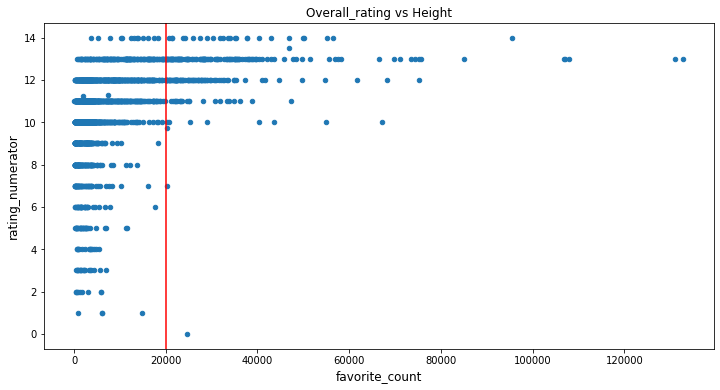

In [136]:
twitter_overall_table.plot(x=['favorite_count'],y=['rating_numerator'],figsize=(12,6), title='Overall_rating vs Height', marker='o', kind='scatter');

plt.ylabel('rating_numerator', fontsize=12)
plt.xlabel('favorite_count', fontsize=12);
plt.axvline(20000, c='red');

The scatter diagram above makes clear that a rating_numerator lower than 10 correlates with a favorite_count of lower than 1000-1500. So the probability that a dog with low WeRateDogs-score gets a favorite_count > 20000 is very low.

See here the 3 dogs which are the exceptions: if you zoom in you see that Logan is really the only exception since the other 2 cases are not predicted as a breed of dog (predicted_dog1 == False):


In [137]:
pd.set_option('display.max_colwidth', 40)
twitter_overall_table.query('rating_numerator < 10 and favorite_count > 20000')  [['tweet_id', 'rating_numerator', 'favorite_count', 'name', 'predicted_dog1']]

,tweet_id,rating_numerator,favorite_count,name,predicted_dog1
246,835152434251116546,0.00,24574,NaN,False
528,786709082849828864,9.75,20296,Logan,True
830,743595368194129920,7.00,20275,Harold,False


See here the record of Logan and you can see that he is prediction as a dog breed but the prediction probability is just 0.46:

In [138]:
pd.set_option('display.max_colwidth', 200)

twitter_overall_table.loc[528]

tweet_id                                                                                                                            786709082849828864
timestamp                                                                                                                    2016-10-13 23:23:56+00:00
source                                                                                                              http://twitter.com/download/iphone
text                  This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
expanded_urls                                                                          https://twitter.com/dog_rates/status/786709082849828864/photo/1
rating_numerator                                                                                                                                  9.75
rating_denominator                                                                            

<br><br>The same finding do we get for the retweet_count, so dogs with a "WeRateDogs' score < 10 get never retweeted >10000 times as you see on the following scatter diagram:

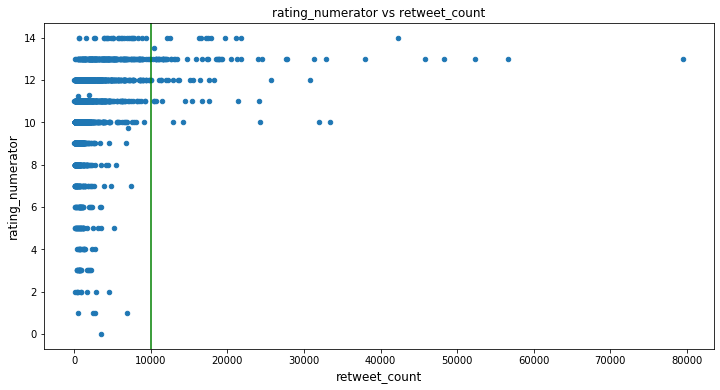

In [139]:
twitter_overall_table.plot(x=['retweet_count'],y=['rating_numerator'],figsize=(12,6), title='rating_numerator vs retweet_count', marker='o', kind='scatter');

plt.ylabel('rating_numerator', fontsize=12)
plt.xlabel('retweet_count', fontsize=12)
plt.axvline(10000, c='green');


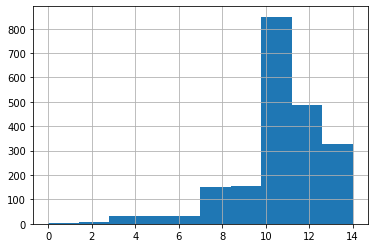

In [140]:
twitter_overall_table.rating_numerator.hist(); 

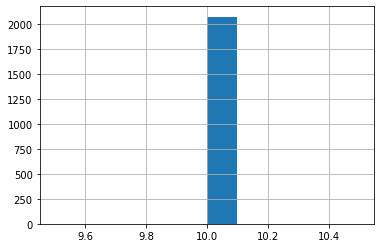

In [141]:
# only dominator scores 10:
twitter_overall_table.rating_denominator.hist(); 

In [142]:
pd.set_option('display.max_colwidth', 25)
twitter_overall_table_dog_only = twitter_overall_table[twitter_overall_table['predicted_dog1'] == True]

In [143]:
print('The total number of rows is for all the observations in the twitter_overall_table:', twitter_overall_table.shape[0])
print('Total number of #1 prediction of something else then a dog is:' , twitter_overall_table.shape[0] - twitter_overall_table_dog_only.shape[0])

print('So we have now', twitter_overall_table_dog_only.shape[0], 'dog predictions left over.')

The total number of rows is for all the observations in the twitter_overall_table: 2078
Total number of #1 prediction of something else then a dog is: 629
So we have now 1449 dog predictions left over.


<br><br>
##### CONCLUSION RESEARCH QUESTION #1: To what extend is there a possitive correlation between a high rating_numerator at the one end, and a higher favorite_count (or retweet_count) at the other hand?
* Only dograce #1 prediction has some predictive power: 50% of the dograce number #1 predictions have a confidence of less than 59%.
* There is only moderate positive correlation between rating_numerator at the one end, and a favorite_count (or retweet_count) at the other hand.
* WeRateDogs score < 10 got never retweeted >10000 times.
* WeRateDogs score < 10 got only favorite_count > 20000 in 3 single cases, which can be explained with that 2 were not #1 predicted as dog while the third case has just a probability of 0.46. Let us continue with Research Question 2 to address this.

<br><br>
### `Research Question #2: Does filtering out of the "non-dog" predictions and the #1 predictions with probability <70% improve the correlation between rating_numerator and retweet_count / favorite_count?`


In [144]:
# see first here again the correlation matrix with ALL rows for all observations:
twitter_overall_table [[ 'rating_numerator','retweet_count', 'favorite_count']].corr()

,rating_numerator,retweet_count,favorite_count
rating_numerator,1.000000,0.313879,0.413777
retweet_count,0.313879,1.000000,0.911327
favorite_count,0.413777,0.911327,1.000000


In [145]:
# and her the correlation with the non-dog predictions taken out:
twitter_overall_table_dog_only [[ 'rating_numerator','retweet_count', 'favorite_count']].corr()

,rating_numerator,retweet_count,favorite_count
rating_numerator,1.000000,0.341517,0.456930
retweet_count,0.341517,1.000000,0.910982
favorite_count,0.456930,0.910982,1.000000


Cel above tells that correlation hardly improves by taking out the non-dog predictions: only +2-4%.


Let us now take out also the #1 predictions with probability <70% (besides the #1 non-dog predictions already taken out):

In [146]:
twitter_overall_table_dog_confident = twitter_overall_table_dog_only[twitter_overall_table_dog_only['pred_confid1'] > 0.7]

In [147]:
twitter_overall_table_dog_confident.shape[0]

612

Taking out observations with probability < 70% does NOT improve the correlation between rating_numerator and retweet_count (even degrades from 0.34 to 0.33).

In [148]:
twitter_overall_table_dog_confident [[ 'rating_numerator','retweet_count', 'favorite_count']].corr()

,rating_numerator,retweet_count,favorite_count
rating_numerator,1.000000,0.329381,0.457275
retweet_count,0.329381,1.000000,0.892012
favorite_count,0.457275,0.892012,1.000000


Let us also here do a visual check:

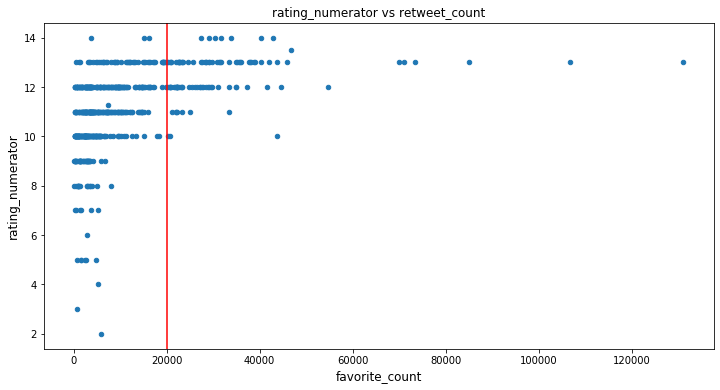

In [149]:
twitter_overall_table_dog_confident.plot(x=['favorite_count'],y=['rating_numerator'],figsize=(12,6), title='rating_numerator vs retweet_count', marker='o', kind='scatter');

plt.ylabel('rating_numerator', fontsize=12)
plt.xlabel('favorite_count', fontsize=12);
plt.axvline(20000, c='red');

In [150]:
pd.set_option('display.max_colwidth', 10000)
twitter_overall_table_dog_confident.query('rating_numerator < 10 and favorite_count > 20000') 

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,img_num,predicted_dograce1,pred_confid1,predicted_dog1,predicted_dograce2,pred_confid2,predicted_dog2,predicted_dograce3,pred_confid3,predicted_dog3


##### CONCLUSION RESEARCH QUESTION #2: Does filtering out of the "non-dog" predictions and the #1 predictions with probability <70% improve the correlation between rating_numerator and retweet_count / favorite_count?
* Taking out observations of non_dogs does NOT or hardly improve the correlation rating_numerator and favorite_count/retweet_count: only + 2-4%.
* Taking out observations with #1 prediction probability < 70% does NOT improve the correlation between rating_numerator and retweet_count (even degrades a bit from 0.34 to 0.33).
* Visual inspections learns that taking out non-dog predictions and low probability #1 predictions is usefull to clean up outliers due to dirty data.

### `Research Question #3: Which dograces (dog breeds) are top performing in terms of rating_numerator ?`

We have the following top 20 rating, after correction for non-dog predictions and predictions with <70% probability:

In [151]:
twitter_overall_table_dog_confident.query('rating_numerator >= 10')  ['predicted_dograce1'].value_counts().head(10)


Golden_retriever      80
Pembroke              50
Labrador_retriever    44
Pug                   28
Chihuahua             25
Samoyed               24
Pomeranian            23
Chow                  19
Toy_poodle            14
French_bulldog        14
Name: predicted_dograce1, dtype: int64

If we focus on only the very high (>= 12) WeRateDogs scores we see that Samoyed climps to position 4 and Pug sinks to position 10 (so Pug had many 10 or 11 scores).

In [152]:
twitter_overall_table_dog_confident.query('rating_numerator >= 12')  ['predicted_dograce1'].value_counts().head(10)

Golden_retriever      58
Pembroke              29
Labrador_retriever    24
Samoyed               15
Chihuahua             14
Chow                  12
French_bulldog         9
Pomeranian             8
German_shepherd        7
Pug                    7
Name: predicted_dograce1, dtype: int64

So the winning bod breed is GOLDEN RETRIEVER !!:

<img src="https://pbs.twimg.com/media/DFYRgsOUQAARGhO.jpg" width="400" height="400" />

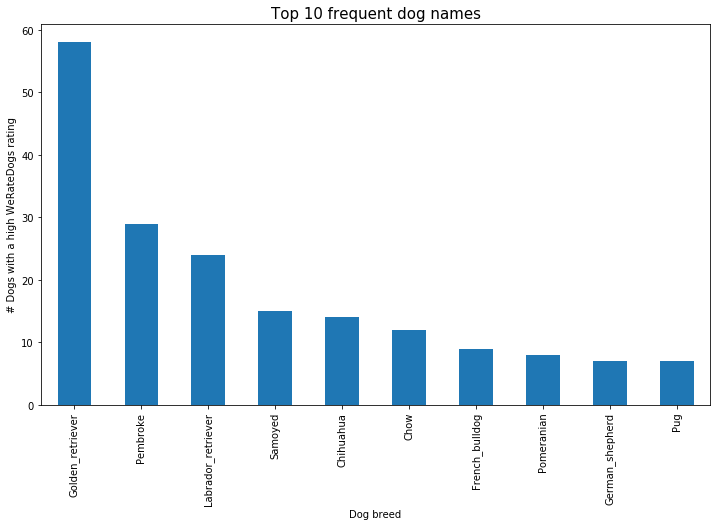

In [153]:
twitter_overall_table_dog_confident.query('rating_numerator >= 12')  ['predicted_dograce1'].value_counts().head(10).plot(kind='bar',figsize=(12,7));
plt.ylabel('# Dogs with a high WeRateDogs rating')
plt.title('Top 10 frequent dog names', size=15)
plt.xlabel('Dog breed')
plt.plot();

Finally see here also a lookup table where you can find the top 'WeRateDogs' scores per predicted dograce:

In [154]:
twitter_overall_table_dog_confident.groupby(['predicted_dograce1','rating_numerator']) ['tweet_id'].count()  .unstack().fillna(0) 

rating_numerator,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,11.27,12.00,13.00,13.50,14.00
predicted_dograce1,,,,,,,,,,,,,,,
Afghan_hound,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Airedale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0
American_staffordshire_terrier,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0
Basenji,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
Basset,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0
Beagle,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
Bernese_mountain_dog,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0
Black-and-tan_coonhound,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Blenheim_spaniel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0


<br><br>
##### CONCLUSION RESEARCH QUESTION #3: Which dograces (dog breeds) are top performing in terms of rating_numerator ?


See here visual with the top 10 of dograces (dog breeds) which is limited to the dogs with a 'WeRateDogs' rate of 12 or higher:

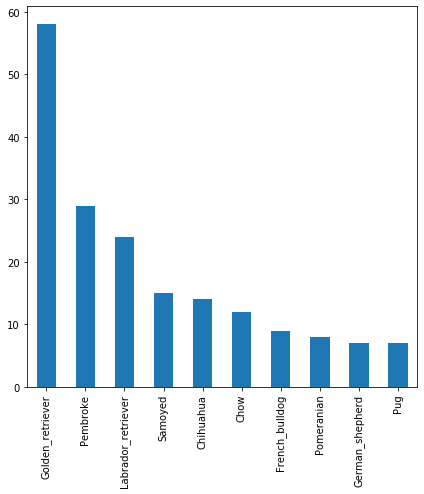

In [155]:
twitter_overall_table_dog_confident.query('rating_numerator >= 12')  ['predicted_dograce1'].value_counts().head(10).plot(kind='bar',figsize=(7,7));

<br><br>
<a id='report'></a>
# 6. Conclusions and Report of this project

<br><br>
The following 2 reports are via standalone documents available:

* `wrangle_report_DIRK_KADIJK_v1.1.html` or `wrangle_report_DIRK_KADIJK_v1.1.ipynb`: this internal report briefly describes the data wrangling and data cleaning efforts.


* `act_report_DIRK_KADIJK_v1.1.html or act_report_DIRK_KADIJK_v1.1.iypnb`: this external report communicates the insights and visalizations produced from the wrangled/cleaned data.
